In [1]:
!pip install torch
!pip install torchvision
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import scipy
from torch.autograd import Variable

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
from pathlib import Path
from typing import Any, Tuple, Callable, Optional
import random
import PIL.Image

class NewFlowers(torchvision.datasets.flowers102.Flowers102):
  def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
    super().__init__(root, split, transform, target_transform, download)
    self._labels = np.array(self._labels, dtype="int")
    
  def __getitem__(self, item):
    
    #obtain indexes of all the labels
    index = np.array(list(range(0, len(self._labels))), dtype="int")
    
    #obtain anchor image 
    anchor_img = self._image_files[item]
    anchor_img = PIL.Image.open(anchor_img).convert("RGB")
    
    #obtain anchor label
    anchor_label = self._labels[item]

    #generate positive index list where it is not the same class as the anchor
    positive_list = index[index!=item][self._labels[index!=item]==anchor_label]
    
    #randomly obtain 1 positive item and its respective image
    positive_item = random.choice(positive_list)
    positive_img = self._image_files[positive_item]
    positive_img = PIL.Image.open(positive_img).convert("RGB")

    #generate negative index list where it is not the same class as the anchor
    negative_list = index[index!=item][self._labels[index!=item]!=anchor_label]
    
    #randomly obtain 1 negative item and its respective image
    negative_item = random.choice(negative_list)
    negative_img = self._image_files[negative_item]
    negative_img = PIL.Image.open(negative_img).convert("RGB")

    #apply transformation on images
    anchor_img = self.transform(anchor_img)
    positive_img = self.transform(positive_img)
    negative_img = self.transform(negative_img)

    return (anchor_img, positive_img, negative_img), anchor_label

In [7]:
triplet_train = NewFlowers("./data/train", split="train", download=True, transform=data_transforms["train"])
triplet_val = NewFlowers("./data/train", split="val", download=True, transform=data_transforms["val"])
triplet_test = NewFlowers("./data/train", split="test", download=True, transform=data_transforms["test"])

100%|██████████| 344862509/344862509 [01:57<00:00, 2935736.18it/s]


Extracting data\train\flowers-102\102flowers.tgz to data\train\flowers-102


100%|██████████| 502/502 [00:00<?, ?it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14990086.47it/s]


In [8]:
triplet_train_dataloader = torch.utils.data.DataLoader(triplet_train, batch_size=4, shuffle=True)
triplet_val_dataloader = torch.utils.data.DataLoader(triplet_val, batch_size=4, shuffle=True)
triplet_test_dataloader = torch.utils.data.DataLoader(triplet_test, batch_size=4, shuffle=True)

In [9]:
image_datasets = {
    'train': triplet_train,
    'val': triplet_val,
    'test': triplet_test
}


dataloaders = {
    "train": triplet_train_dataloader,
    "val": triplet_val_dataloader,
    "test": triplet_test_dataloader,
}

dataset_sizes = {
        x: len(dataloaders[x].dataset)
        for x in list(image_datasets.keys())
    }

In [10]:
dataset_sizes

{'train': 1020, 'val': 1020, 'test': 6149}

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
anchor, positive, negative = 0,0,0
for i, (inputs, labels) in enumerate(triplet_train_dataloader):
#     print(labels)
    anchor, positive, negative = inputs
    break

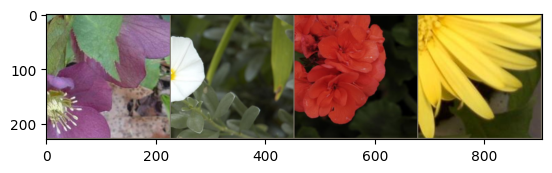

In [13]:
anchor_out = torchvision.utils.make_grid(anchor)
imshow(anchor_out)

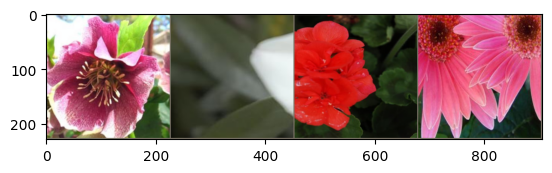

In [14]:
positive_out = torchvision.utils.make_grid(positive)
imshow(positive_out)

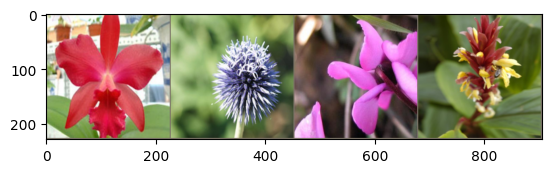

In [15]:
negative_out = torchvision.utils.make_grid(negative)
imshow(negative_out)

In [16]:
import torch
import torch.nn as nn
import time

def train_model(model, optimizer, criterion, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    
    # Initialize lists to store metrics
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    # Detect if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move the model to the correct device
    model.to(device)

    # Initialize CrossEntropyLoss
    cross_entropy_loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data in the dataloader
            for inputs, anchor_label in dataloaders[phase]:
                # Move inputs and labels to the selected device
                anchor_label = anchor_label.to(device).long()  # Ensure labels are of type LongTensor

                # Unpack inputs (anchor, positive, negative)
                anchor_img, positive_img, negative_img = inputs
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Get outputs from the model
                    anchor_out = model(anchor_img)
                    positive_out = model(positive_img)
                    negative_out = model(negative_img)
                    
                    # Predictions for accuracy calculation
                    _, preds = torch.max(anchor_out, 1)
                    
                    # Calculate Triplet loss
                    triplet_loss = criterion(anchor_out, positive_out, negative_out)
                    
                    # Calculate CrossEntropy loss
                    ce_loss = cross_entropy_loss(anchor_out, anchor_label)
                    
                    # Combine losses
                    total_loss = triplet_loss + ce_loss

                    # Backpropagation and optimization if in training phase
                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

                # Accumulate loss and accuracy statistics
                running_loss += total_loss.item() * anchor_label.size(0)
                running_corrects += torch.sum(preds == anchor_label.data)

            # Step the scheduler if in training phase
            if phase == 'train':
                scheduler.step()

            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_loss, train_acc, val_loss, val_acc


In [17]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [18]:
model_path = './transformer_vit_b_16_freeze_TripletLoss_CrossEntropyLoss_GPU.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    loaded_transformer = torch.load(model_path)
    
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model_conv = models.resnet18(weights='IMAGENET1K_V1')
    
    #freezing all other layers
    for param in model_conv.parameters():
        param.requires_grad = False
        
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 102)

Model checkpoint does not exist.


In [19]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
num_epochs = 40

model_conv = model_conv.to(device)

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)

In [21]:
model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, optimizer_conv, criterion, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

Using device: cuda
Epoch 1/40
----------
train Loss: 5.0901 Acc: 0.0206
val Loss: 4.0632 Acc: 0.1500

Epoch 2/40
----------
train Loss: 4.2742 Acc: 0.1088
val Loss: 3.2143 Acc: 0.3529

Epoch 3/40
----------
train Loss: 3.6927 Acc: 0.2324
val Loss: 2.5844 Acc: 0.4931

Epoch 4/40
----------
train Loss: 3.1765 Acc: 0.3696
val Loss: 2.2219 Acc: 0.5922

Epoch 5/40
----------
train Loss: 2.8574 Acc: 0.4529
val Loss: 1.8989 Acc: 0.6461

Epoch 6/40
----------
train Loss: 2.6871 Acc: 0.5029
val Loss: 1.6997 Acc: 0.6873

Epoch 7/40
----------
train Loss: 2.3489 Acc: 0.5755
val Loss: 1.4585 Acc: 0.7373

Epoch 8/40
----------
train Loss: 2.1913 Acc: 0.6186
val Loss: 1.3047 Acc: 0.7549

Epoch 9/40
----------
train Loss: 2.0330 Acc: 0.6363
val Loss: 1.2873 Acc: 0.7520

Epoch 10/40
----------
train Loss: 1.8910 Acc: 0.6657
val Loss: 1.2178 Acc: 0.7676

Epoch 11/40
----------
train Loss: 1.7457 Acc: 0.6951
val Loss: 1.2115 Acc: 0.7696

Epoch 12/40
----------
train Loss: 1.6425 Acc: 0.7324
val Loss: 1.

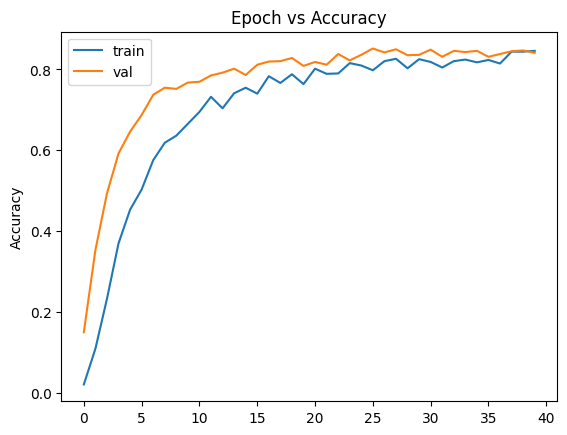

In [22]:
plot_graph(num_epochs, train_acc, val_acc, "Epoch vs Accuracy")

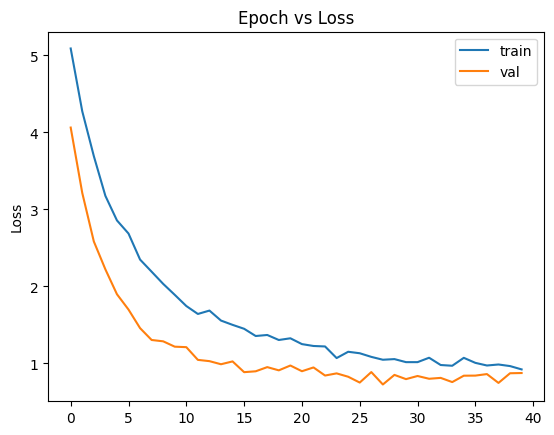

In [23]:
plot_graph(num_epochs, train_loss, val_loss, "Epoch vs Loss")

In [24]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    correct = 0
    with torch.no_grad():
        for i, (inputs, anchor_label) in enumerate(dataloaders['test']):

            anchor_label = anchor_label.to(device)
            
            anchor_img, _, _ = inputs
            anchor_img = anchor_img.to(device)
            
        
            anchor_out = model(anchor_img)

            _, preds = torch.max(anchor_out, 1)

            preds = preds.to(device)

            correct += torch.sum(preds == anchor_label.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {anchor_label[0]}')

    correct = correct.double() / size
    model.train(mode=was_training)
    return correct

In [26]:
test_acc = test(model_conv)

Predicted: 77 | True: 77
Predicted: 56 | True: 56
Predicted: 25 | True: 25
Predicted: 14 | True: 14
Predicted: 89 | True: 42
Predicted: 89 | True: 89
Predicted: 80 | True: 80
Predicted: 71 | True: 71
Predicted: 89 | True: 89
Predicted: 67 | True: 67
Predicted: 72 | True: 72
Predicted: 25 | True: 25
Predicted: 27 | True: 75
Predicted: 28 | True: 76
Predicted: 34 | True: 34
Predicted: 11 | True: 11
Predicted: 88 | True: 88
Predicted: 43 | True: 43
Predicted: 17 | True: 17
Predicted: 71 | True: 71
Predicted: 93 | True: 93
Predicted: 77 | True: 77
Predicted: 77 | True: 77
Predicted: 59 | True: 59
Predicted: 12 | True: 12
Predicted: 90 | True: 74
Predicted: 76 | True: 76
Predicted: 51 | True: 51
Predicted: 80 | True: 80
Predicted: 41 | True: 42
Predicted: 16 | True: 16
Predicted: 59 | True: 59
Predicted: 18 | True: 18
Predicted: 75 | True: 75
Predicted: 45 | True: 45
Predicted: 85 | True: 75
Predicted: 47 | True: 47
Predicted: 9 | True: 37
Predicted: 23 | True: 23
Predicted: 8 | True: 8
Pre

In [ ]:
print(f"Test Acc: {test_acc}")

Test Acc: 0.7884208814441372
